In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from google.colab import files
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten,Input,Conv2D, MaxPooling2D,Dropout,BatchNormalization,Reshape,Conv2DTranspose,ReLU,LeakyReLU
import random
import itertools
from sklearn.metrics import classification_report,confusion_matrix
from keras.utils import plot_model, np_utils,to_categorical
from keras.optimizers import Adam,RMSprop
from keras.constraints import Constraint
from keras import initializers,losses
from keras import backend
from keras import backend as K
import os
from PIL import Image

plt.style.use('ggplot')

In [2]:
#https://drive.google.com/file/d/13cVJC8dhuRKdRZrRgrtPZoPFtN_UrYjV/view?usp=share_link
!gdown 13cVJC8dhuRKdRZrRgrtPZoPFtN_UrYjV

Downloading...
From: https://drive.google.com/uc?id=13cVJC8dhuRKdRZrRgrtPZoPFtN_UrYjV
To: /content/Dataset.zip
100% 807k/807k [00:00<00:00, 162MB/s]


In [3]:
!unzip Dataset.zip

Archive:  Dataset.zip
   creating: Dataset/
   creating: Dataset/Class 1/
  inflating: Dataset/Class 1/0.png   
  inflating: Dataset/Class 1/1.png   
  inflating: Dataset/Class 1/10.png  
  inflating: Dataset/Class 1/100.png  
  inflating: Dataset/Class 1/101.png  
  inflating: Dataset/Class 1/102.png  
  inflating: Dataset/Class 1/103.png  
  inflating: Dataset/Class 1/104.png  
  inflating: Dataset/Class 1/105.png  
  inflating: Dataset/Class 1/106.png  
  inflating: Dataset/Class 1/107.png  
  inflating: Dataset/Class 1/108.png  
  inflating: Dataset/Class 1/109.png  
  inflating: Dataset/Class 1/11.png  
  inflating: Dataset/Class 1/110.png  
  inflating: Dataset/Class 1/111.png  
  inflating: Dataset/Class 1/112.png  
  inflating: Dataset/Class 1/113.png  
  inflating: Dataset/Class 1/114.png  
  inflating: Dataset/Class 1/115.png  
  inflating: Dataset/Class 1/116.png  
  inflating: Dataset/Class 1/117.png  
  inflating: Dataset/Class 1/118.png  
  inflating: Dataset/Class 1/119.

In [4]:
def load_images():

  images = []
  labels = []
  root_dir='Dataset'
  class_dirs = []
  for i in range(1,6):
    class_dirs.append('Class '+str(i))

  for i in range(1,6):
    img_dir = os.path.join(root_dir,class_dirs[i-1])
    imge_files = []
    for root, dirs, files in os.walk(img_dir):
      imge_files.extend(files)
    imge_files = sorted(imge_files)
    for img in imge_files:
      image_path = os.path.join(img_dir,img)
      image = Image.open(image_path)
      image = image.resize((28,28))
      images.append(np.array(image))
      labels.append(i)
    
  return np.array(images),np.array(labels)



In [5]:
images,labels = load_images()

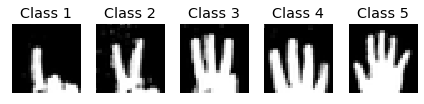

In [6]:
fig = plt.figure()
for i in range(1,6):
    plt.subplot(2, 5, i)
    x_y = images[labels == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [7]:
#pre-processing
images = images.reshape(images.shape[0], 28, 28, 1).astype('float32')
images = (images - 127.5) / 127.5


In [8]:
images.shape

(1005, 28, 28, 1)

In [10]:
# train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(images.shape[0]).batch(batch_size)

In [9]:
# Parameters
latent_dim = 100
n_critic = 3
clip_value = 0.05
learning_rate=0.0008
epochs = 100
batch_size = 64
samples = 10

In [10]:
#Generator
generator = Sequential()

generator.add(Dense(7*7*512, input_shape=(latent_dim,), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(Reshape((7, 7, 512)))

generator.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

generator.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

generator.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same',activation='tanh'))

In [11]:
generator.summary(line_length=150)

Model: "sequential"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                
 dense (Dense)                                                     (None, 25088)                                               2533888                
                                                                                                                                                      
 reshape (Reshape)                                                 (None, 7, 7, 512)                                           0                      
                                                                                                                                                      
 conv2d_transpose (Conv2DTranspose)                                (None, 

In [12]:
# Critic
critic = Sequential()

critic.add(Conv2D(64, kernel_size=3, strides=2, padding='same',input_shape=(images[0].shape)))
critic.add(LeakyReLU(0.2))

critic.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
critic.add(BatchNormalization(momentum=0.8))
critic.add(LeakyReLU(0.2))

critic.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
critic.add(BatchNormalization(momentum=0.8))
critic.add(LeakyReLU(0.2))

critic.add(Conv2D(512, kernel_size=3, strides=1, padding='same'))
critic.add(BatchNormalization(momentum=0.8))
critic.add(LeakyReLU(0.2))

critic.add(Flatten())

critic.add(Dense(1))

In [13]:
critic.summary(line_length=150)

Model: "sequential_1"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                
 conv2d (Conv2D)                                                   (None, 14, 14, 64)                                          640                    
                                                                                                                                                      
 leaky_re_lu (LeakyReLU)                                           (None, 14, 14, 64)                                          0                      
                                                                                                                                                      
 conv2d_1 (Conv2D)                                                 (None

In [14]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [15]:
optimizer = RMSprop(learning_rate=learning_rate)
critic.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])

In [16]:
critic.trainable = False
z = Input(shape=(latent_dim,))
img = generator(z)
valid = critic(img)
wgan = Model(inputs=z, outputs=valid, name='wgan')
wgan.compile(optimizer=optimizer, loss=wasserstein_loss, metrics=['accuracy'])

In [17]:
def show_results(predictions):
  
  fig = plt.figure(figsize=(5, 5))
  for i in range(predictions.shape[0]):
      plt.subplot(2, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.tight_layout()
  plt.show()

epoch = 0/100, d_loss=-15.132, g_loss=8.498, d_acc=0.62665, g_acc=0.00000                                                                                                     


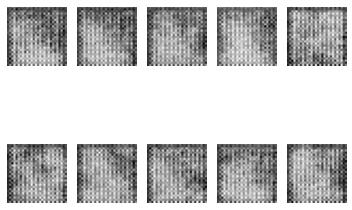

epoch = 1/100, d_loss=-19.218, g_loss=10.721, d_acc=0.91047, g_acc=0.00000                                                                                                     
epoch = 2/100, d_loss=-19.604, g_loss=10.830, d_acc=0.94709, g_acc=0.00000                                                                                                     
epoch = 3/100, d_loss=-19.952, g_loss=10.087, d_acc=0.96231, g_acc=0.00000                                                                                                     
epoch = 4/100, d_loss=-19.997, g_loss=11.129, d_acc=0.97070, g_acc=0.00000                                                                                                     
epoch = 5/100, d_loss=-19.893, g_loss=12.075, d_acc=0.97603, g_acc=0.00000                                                                                                     
epoch = 6/100, d_loss=-19.964, g_loss=10.117, d_acc=0.97971, g_acc=0.00000                                              

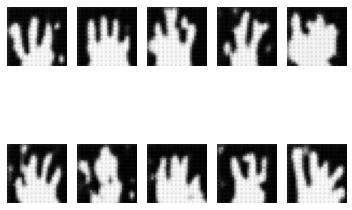

epoch = 11/100, d_loss=-16.552, g_loss=15.448, d_acc=0.96555, g_acc=0.02097                                                                                                     
epoch = 12/100, d_loss=-6.467, g_loss=5.301, d_acc=0.96138, g_acc=0.02076                                                                                                     
epoch = 13/100, d_loss=-19.280, g_loss=12.981, d_acc=0.95740, g_acc=0.02115                                                                                                     
epoch = 14/100, d_loss=-19.180, g_loss=12.945, d_acc=0.95701, g_acc=0.02735                                                                                                     
epoch = 15/100, d_loss=-18.579, g_loss=13.916, d_acc=0.95354, g_acc=0.02673                                                                                                     
epoch = 16/100, d_loss=-18.314, g_loss=15.100, d_acc=0.94333, g_acc=0.02541                                          

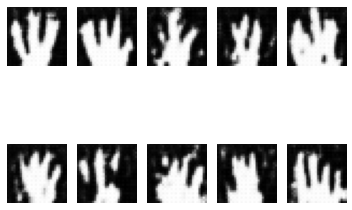

epoch = 21/100, d_loss=-17.746, g_loss=17.202, d_acc=0.89562, g_acc=0.02013                                                                                                     
epoch = 22/100, d_loss=-18.002, g_loss=16.187, d_acc=0.88708, g_acc=0.01923                                                                                                     
epoch = 23/100, d_loss=-18.370, g_loss=15.838, d_acc=0.88182, g_acc=0.01842                                                                                                     
epoch = 24/100, d_loss=-18.220, g_loss=15.424, d_acc=0.87860, g_acc=0.01767                                                                                                     
epoch = 25/100, d_loss=-18.500, g_loss=14.524, d_acc=0.87605, g_acc=0.01697                                                                                                     
epoch = 26/100, d_loss=-18.574, g_loss=14.896, d_acc=0.87360, g_acc=0.01633                                        

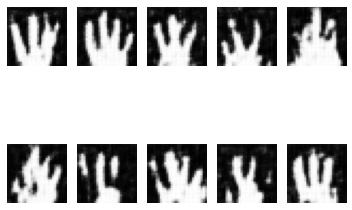

epoch = 31/100, d_loss=-18.883, g_loss=14.110, d_acc=0.86807, g_acc=0.01485                                                                                                     
epoch = 32/100, d_loss=-18.896, g_loss=13.569, d_acc=0.86592, g_acc=0.01455                                                                                                     
epoch = 33/100, d_loss=-18.838, g_loss=12.102, d_acc=0.86374, g_acc=0.01430                                                                                                     
epoch = 34/100, d_loss=-19.078, g_loss=13.411, d_acc=0.86093, g_acc=0.01409                                                                                                     
epoch = 35/100, d_loss=-18.932, g_loss=12.249, d_acc=0.85844, g_acc=0.01377                                                                                                     
epoch = 36/100, d_loss=-18.804, g_loss=13.146, d_acc=0.85528, g_acc=0.01372                                        

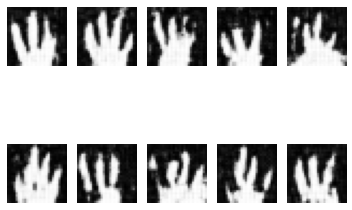

epoch = 41/100, d_loss=-19.047, g_loss=11.508, d_acc=0.83536, g_acc=0.01236                                                                                                     
epoch = 42/100, d_loss=-19.125, g_loss=11.296, d_acc=0.83120, g_acc=0.01207                                                                                                     
epoch = 43/100, d_loss=-19.253, g_loss=12.207, d_acc=0.82818, g_acc=0.01179                                                                                                     
epoch = 44/100, d_loss=-19.177, g_loss=11.586, d_acc=0.82579, g_acc=0.01153                                                                                                     
epoch = 45/100, d_loss=-19.281, g_loss=12.068, d_acc=0.82351, g_acc=0.01127                                                                                                     
epoch = 46/100, d_loss=-18.823, g_loss=10.971, d_acc=0.82121, g_acc=0.01103                                        

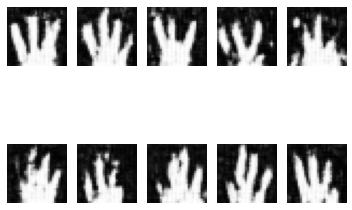

epoch = 51/100, d_loss=-19.105, g_loss=11.459, d_acc=0.80618, g_acc=0.01048                                                                                                     
epoch = 52/100, d_loss=-19.268, g_loss=12.604, d_acc=0.80199, g_acc=0.01028                                                                                                     
epoch = 53/100, d_loss=-19.307, g_loss=11.747, d_acc=0.79847, g_acc=0.01009                                                                                                     
epoch = 54/100, d_loss=-19.204, g_loss=12.217, d_acc=0.79391, g_acc=0.00996                                                                                                     
epoch = 55/100, d_loss=-19.252, g_loss=11.539, d_acc=0.79019, g_acc=0.00984                                                                                                     
epoch = 56/100, d_loss=-19.085, g_loss=11.727, d_acc=0.78626, g_acc=0.00969                                        

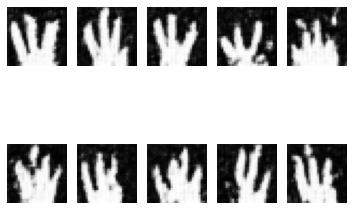

epoch = 61/100, d_loss=-19.352, g_loss=11.011, d_acc=0.76314, g_acc=0.00910                                                                                                     
epoch = 62/100, d_loss=-19.375, g_loss=11.232, d_acc=0.75754, g_acc=0.00896                                                                                                     
epoch = 63/100, d_loss=-19.351, g_loss=10.559, d_acc=0.75169, g_acc=0.00892                                                                                                     
epoch = 64/100, d_loss=-19.225, g_loss=10.108, d_acc=0.74634, g_acc=0.00919                                                                                                     
epoch = 65/100, d_loss=-19.404, g_loss=11.158, d_acc=0.74072, g_acc=0.00905                                                                                                     
epoch = 66/100, d_loss=-19.476, g_loss=10.008, d_acc=0.73586, g_acc=0.00892                                        

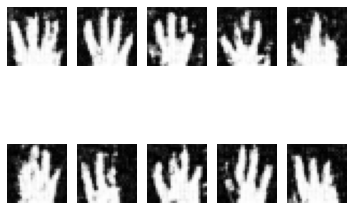

epoch = 71/100, d_loss=-19.283, g_loss=7.884, d_acc=0.70816, g_acc=0.00829                                                                                                     
epoch = 72/100, d_loss=-19.255, g_loss=11.177, d_acc=0.70331, g_acc=0.00818                                                                                                     
epoch = 73/100, d_loss=-19.612, g_loss=8.134, d_acc=0.69923, g_acc=0.00807                                                                                                     
epoch = 74/100, d_loss=-19.446, g_loss=9.325, d_acc=0.69532, g_acc=0.00796                                                                                                     
epoch = 75/100, d_loss=-17.900, g_loss=14.400, d_acc=0.69126, g_acc=0.00789                                                                                                     
epoch = 76/100, d_loss=-19.543, g_loss=8.833, d_acc=0.68704, g_acc=0.00784                                            

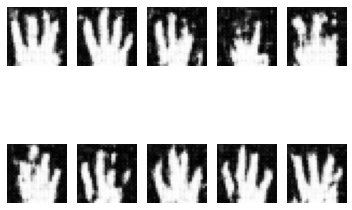

epoch = 81/100, d_loss=-19.434, g_loss=7.980, d_acc=0.67732, g_acc=0.00804                                                                                                     
epoch = 82/100, d_loss=-19.097, g_loss=9.651, d_acc=0.67586, g_acc=0.00803                                                                                                     
epoch = 83/100, d_loss=-19.614, g_loss=6.136, d_acc=0.67395, g_acc=0.00804                                                                                                     
epoch = 84/100, d_loss=-19.588, g_loss=7.299, d_acc=0.67212, g_acc=0.00810                                                                                                     
epoch = 85/100, d_loss=-19.703, g_loss=5.565, d_acc=0.66960, g_acc=0.00811                                                                                                     
epoch = 86/100, d_loss=-19.525, g_loss=6.899, d_acc=0.66718, g_acc=0.00801                                              

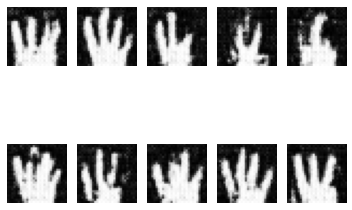

epoch = 91/100, d_loss=-19.755, g_loss=4.052, d_acc=0.65552, g_acc=0.00845                                                                                                     
epoch = 92/100, d_loss=-19.830, g_loss=3.851, d_acc=0.65369, g_acc=0.00846                                                                                                     
epoch = 93/100, d_loss=-19.716, g_loss=3.482, d_acc=0.65265, g_acc=0.00849                                                                                                     
epoch = 94/100, d_loss=-19.837, g_loss=3.494, d_acc=0.65166, g_acc=0.00896                                                                                                     
epoch = 95/100, d_loss=-19.685, g_loss=2.183, d_acc=0.65058, g_acc=0.00950                                                                                                     
epoch = 96/100, d_loss=-19.851, g_loss=2.613, d_acc=0.64953, g_acc=0.00997                                              

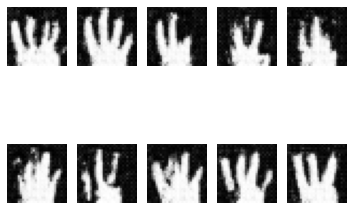

In [18]:
real = -np.ones(shape=(batch_size, 1))
fake = np.ones(shape=(batch_size, 1))

critic_accuracy = tf.keras.metrics.BinaryAccuracy()
generator_accuracy = tf.keras.metrics.BinaryAccuracy()

noise = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))

d_loss = []
g_loss = []
d_acc = []
g_acc = []

for e in range(epochs + 1):

    d_acc_epoch = []
    g_acc_epoch = []
    for i in range(len(images) // batch_size):

        X_batch = images[i*batch_size:(i+1)*batch_size]
        for _ in range(n_critic):

            # Train Discriminator weights
            critic.trainable = True

            # Real samples
            
            d_loss_real = critic.train_on_batch(x=X_batch, y=real)

            # Fake Samples
            z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
            X_fake = generator.predict(z,verbose=0)
            d_loss_fake = critic.train_on_batch(x=X_fake, y=fake)

            # Discriminator loss
            d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

            
            for l in critic.layers:
                weights = l.get_weights()
                weights = [np.clip(w, -clip_value, clip_value) for w in weights]
                l.set_weights(weights)


        # Train Generator weights
        critic.trainable = False
        g_loss_batch = wgan.train_on_batch(x=z, y=real)

        #accuracy
        d_out = critic.predict(X_batch,verbose=0)
        d_acc_epoch.append(critic_accuracy(tf.ones_like(d_out),d_out))
        g_out = generator.predict(noise,verbose=0)
        d_fake_out = critic.predict(g_out,verbose=0)
        g_acc_epoch.append(generator_accuracy(tf.ones_like(d_fake_out),d_fake_out))
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    d_acc.append(tf.math.reduce_mean(d_acc_epoch))
    g_acc.append(tf.math.reduce_mean(g_acc_epoch))
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f, d_acc=%.5f, g_acc=%.5f' % (e, epochs, d_loss[-1], g_loss[-1],d_acc[-1],g_acc[-1]), 100*' ')

    if (e) % 10 == 0:
        x_fake = generator.predict(noise,verbose=0)
        show_results(x_fake)
        

In [19]:
def plot_metrics(hist,title,metric):
  fig , ax = plt.subplots(figsize = (10,8))
  ax.plot(hist[0])
  ax.plot(hist[1])
  ax.legend(['Discriminator', 'Generator']) 
  ax.set_xlabel('Epoch')
  ax.set_ylabel(metric)
  ax.set_title(title)
  plt.show()

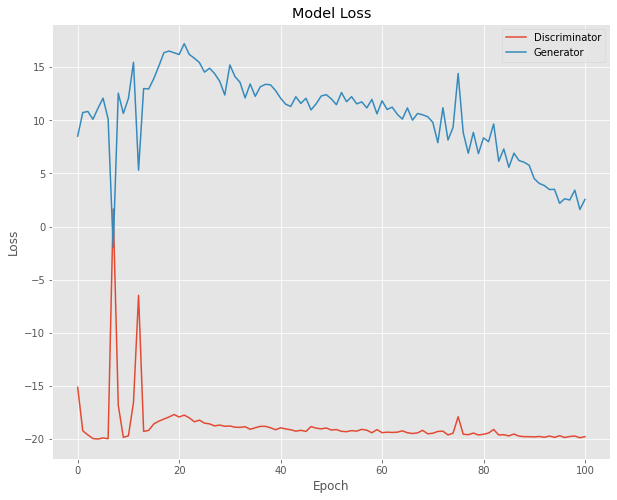

In [20]:
plot_metrics([d_loss,g_loss],'Model Loss','Loss')

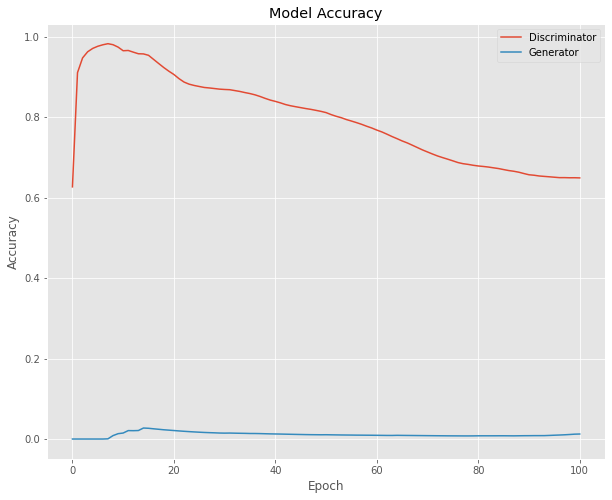

In [21]:
plot_metrics([d_acc,g_acc],'Model Accuracy','Accuracy')